In [1]:
import pandas as pd
import openpyxl

# Functions

In [2]:
def create_pie(excel_file):
    """
    Creates a pie chart with the contribution of  greenhouse
    gases of each transportation used by the user.
    """
    import plotly.express as px
    
    df = pd.read_excel(excel_file)
    categories = ["car", "ferry", "bus", "rail", "bike"]
    values = df[categories].sum()
    #create pie
    pie = px.pie(df, values=values, names=categories, title="Emissions in %")
    pie.update_traces(
        textposition = "inside", textinfo="percent+label"
    )
    pie.update_layout(title_font_size = 42)
    pie = px.pie(df, values=values, names=categories, title="Emissions in %")

    pie.update_traces(
            textposition = "inside", textinfo="percent+label"
    )
    pie.update_layout(title_font_size = 42)
    pie.show()

In [3]:
def plot_time_series(excel_sheet, country):
    """
    Creates a timeseries of the user's historical CO2e emission
    """
    import plotly.graph_objects as go
    import numpy as np
    
    df2 = pd.read_excel(excel_sheet)
    total = df2.set_index('date')['total']
    def _mean(country):
        edgar_df = pd.read_excel('EDGARv6.0_FT2020_fossil_CO2_GHG_booklet2021.xls', sheet_name = 'GHG_by_sector_and_country')
        #transportation co2 consumption[Mton] in 2018
        transportation_ghg = edgar_df[edgar_df.Sector == 'Transport'][['Country',2018]].set_index('Country')
        #population_data_frame
        pop_df = pd.read_excel('API_SP.POP.TOTL_DS2_en_excel_v2_3052521.xlsx', sheet_name = 'Data', skiprows = 3, index_col = 'Country Name')
        pop_2018 = pop_df['2018']
        #countries that are in both df
        same_countries = [index for index in transportation_ghg.index  if index in pop_2018.index]
        same_countries
        # 2018 mean ghg consumption in kgco2e per country per habitant
        ghg_2018_mean= transportation_ghg.loc[same_countries, 2018]/pop_2018[same_countries]*1e9/365
        return ghg_2018_mean[country]
    mean = _mean(country)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=total.index, y=total, fill=None, name = 'your CO2e emission'))
    fig.add_trace(go.Scatter(x=total.index, y=np.ones(total.shape[0])*mean, fill='tonexty', name = f'Mean  CO2e emission in {country}')) 
    fig.add_trace(go.Scatter(x=total.index, y=np.ones(total.shape[0])*total.mean(), fill=None, name = "your CO2e emission's mean"))
    fig.update_yaxes(title_text="Daily CO2e emission [kg]")
    fig.show()

# Transportation Databases

In [4]:
# cars database
df = pd.read_excel('conversion-factors-2021-full-set-advanced-users.xlsm',
    sheet_name = r'Passenger vehicles', skiprows = 23, nrows = 43-24+1-2, #nrows - 2 headers. See excel rows.
    header = [0,1]
    )
#selecting all the different cars
cars_type = df['Unnamed: 2_level_0'].Type.dropna().unique()
# Dropping unnamed values. I will add them by brute force
df_1 = df.drop(df.filter(regex="Unname"),axis=1)
# Deletting Electric Vehicles becase the dataset doesn't have any information about them
# I will also remove the Unknown Column
df_1.drop(['Battery Electric Vehicle', 'Unknown'], axis = 1, level = 0,inplace = True)
df_1.drop('Unknown', axis = 1, level = 0, inplace = True)
#drop all columns except for the kg of CO2eq
df_1.drop(df.Diesel.columns.drop('kg CO2e'), level = 1, axis = 1, inplace = True)
#adding km column
df_1['Unit'] = df['Unnamed: 3_level_0']
#deleting miles
df_1.drop(index = df_1[df_1.Unit=='miles'].index, inplace = True)
df_1.index = cars_type 
df_1 = df_1.droplevel(1, axis =1)
df_car = df_1.copy()

In [5]:
# Ferry database
df_ferry = pd.read_excel('conversion-factors-2021-full-set-advanced-users.xlsm',
    sheet_name = r'WTT- business travel- sea')
ferry=df_ferry.iloc[[15,16,17,18],[2,4]]

In [6]:
# bus database
df_bus = pd.read_excel('conversion-factors-2021-full-set-advanced-users.xlsm',
    sheet_name = r'Business travel- land')
bus=df_bus.iloc[[76,77,78,79],[2,3,4]]

In [7]:
#motorbike database
df = pd.read_excel('conversion-factors-2021-full-set-advanced-users.xlsm',
    sheet_name = r'Passenger vehicles', skiprows = 58, nrows = 8,
    usecols="C:H")
df_bike = df.loc[:, "Type":"kg CO2e"]
milesdrop = df_bike[df_bike["Unit"]=="miles"].index
df_bike.drop(milesdrop, inplace=True)
df_bike.drop("Unit", axis=1, inplace=True)

In [8]:
#rail database
df_rail = pd.read_excel('conversion-factors-2021-full-set-advanced-users.xlsm',
                       sheet_name='Business travel- land', skiprows=85, nrows=4, usecols="C,E")

# Questions

In [14]:
country = input('Where are you living? ')

Where are you living?  United Kingdom


In [15]:
co2_car=0
co2_ferry=0
co2_bus=0
co2_rail=0
co2_bike=0
while True:
    vehicle=input("Which kind of vehicle did you use for transportation? bike, rail, bus, ferry or car?")
    ###########
    if vehicle == "car":
        fuel = input("What kind of fuel: Diesel or Petrol?")
        car_type = int(input("""Press 1 for small cars, 2 for super mini cars( smaller than family cars), 
        3 for small family cars, 4 for big family cars, 5 for executive cars,6 for luxury cars, 7 for sports cars, 
        8  for 4x4 cars and 9 for multipurpose cars"""))
        distance_car=float(input("How many kilometers did you travel by car?"))
        co2_car=distance_car*(float(df_car.loc[df_car.index[car_type -1],fuel]))
        print("You have produced", co2_car, "CO2 equivalents by travelling for", distance_car, "kilometers by car.")
        x=input("Type 'finished' if you are done or type 'additional' for adding another transportation.")
        if x=="additional":
            continue
        elif x=='finished':
            break
    ###########
    elif vehicle == "ferry":
        distance_ferry=float(input("How far did you travel in kilometers"))
        #number_ferry=float(input("For how many people on the ferry do you want to calculate your footprint?"))
        car_ferry=input("Did you take your car to the ferry? yes or no?")
        if car_ferry == "yes":
            car_ferry = 1
            number_ferry = int(input("How many people shared one car together on your ferry trip?"))
        else:
            car_ferry = 0
        co2_ferry=distance_ferry*(float(ferry.iloc[1,1]) + (car_ferry*number_ferry *float(ferry.iloc[2,1])))
        #print(co2_ferry)
        print("You have used ", co2_ferry, " CO2 equivalents per person.")
        x=input("Type 'finished' if you are done or type 'additional' for adding another transportation.")
        if x=="additional":
            continue
        elif x=='finished':  
            break
    #########      
    elif vehicle == "bus":
        distance_bus=float(input("How many kilometers did you travel by bus?"))
        co2_bus=distance_bus*(float(bus.iloc[3,2]))
        print("You have produced", co2_bus, "CO2 equivalents by travelling for", distance_bus, "kilometers by bus.")
        x=input("Type 'finished' if you are done or type 'additional' for adding another transportation.")
        if x=="additional":
            continue
        elif x=='finished':
            break
    ##########
    elif vehicle == "rail":
        railtype=int(input("Press 1 for national rail, 2 for international rail, 3 for tram or 4 for underground rail?"))
        distance_rail=float(input("How many kilometers did you travel by rail?"))
        co2_rail=distance_rail*(float(df_rail.iloc[railtype-1,1]))
        print("You have produced", co2_rail, "CO2 equivalents by travelling for", distance_rail, "kilometers by rail.")
        x=input("Type 'finished' if you are done or type 'additional' for adding another transportation.")
        if x=="additional":
            continue
        elif x=='finished':
            break
    ##########
    elif vehicle == "bike":
        biketype=int(input("Press 1 for small, 2 for medium and 3 for the usage of a large bike?"))
        distance_bike=float(input("How many kilometers did you travel by bike?"))
        co2_bike=distance_bike*(float(df_bike.iloc[biketype-1,1]))
        print("You have produced", co2_bike, "CO2 equivalents by travelling for", distance_bike, "kilometers by bike.")
        x=input("Type 'finished' if you are done or type 'additional' for adding another transportation.")
        if x=="additional":
            continue
        elif x=='finished':
            break

Which kind of vehicle did you use for transportation? bike, rail, bus, ferry or car? car
What kind of fuel: Diesel or Petrol? Diesel
Press 1 for small cars, 2 for super mini cars( smaller than family cars), 
        3 for small family cars, 4 for big family cars, 5 for executive cars,6 for luxury cars, 7 for sports cars, 
        8  for 4x4 cars and 9 for multipurpose cars 7
How many kilometers did you travel by car? 30


You have produced 4.9992 CO2 equivalents by travelling for 30.0 kilometers by car.


Type 'finished' if you are done or type 'additional' for adding another transportation. finished


In [16]:
date=input("Do you want to type in data from a different date, then please type in the desired date in the following format: 2021-10-27, else type in 'today'")
if date == "today":
    from datetime import date
    date=date.today()
print(date)  
# the database should be here
wbkName = 'CO2-emissions-transportation.xlsx'
wbk = openpyxl.load_workbook(wbkName)
for wks in wbk.worksheets:
    for myRow in range (1,1001):#Table can store at maximum 1000 days
        if wks.cell(row=myRow, column=1).value==None:
            wks.cell(row=myRow, column=1).value=date
            wks.cell(row=myRow, column=2).value=co2_car
            wks.cell(row=myRow, column=3).value=co2_ferry
            wks.cell(row=myRow, column=4).value=co2_bus
            wks.cell(row=myRow, column=5).value=co2_rail
            wks.cell(row=myRow, column=6).value=co2_bike
            wks.cell(row=myRow, column=7).value=co2_bike+co2_rail+co2_bus+co2_ferry+co2_car
            break
wbk.save(wbkName)
wbk.close()

Do you want to type in data from a different date, then please type in the desired date in the following format: 2021-10-27, else type in 'today' today


2021-10-31


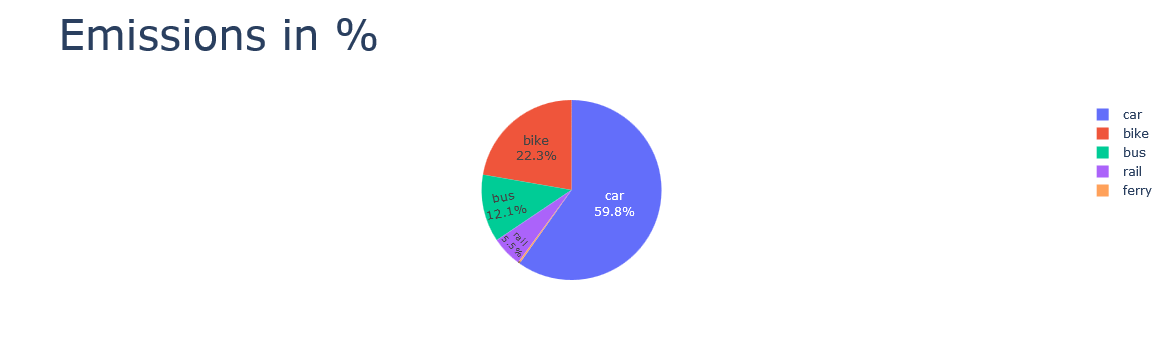

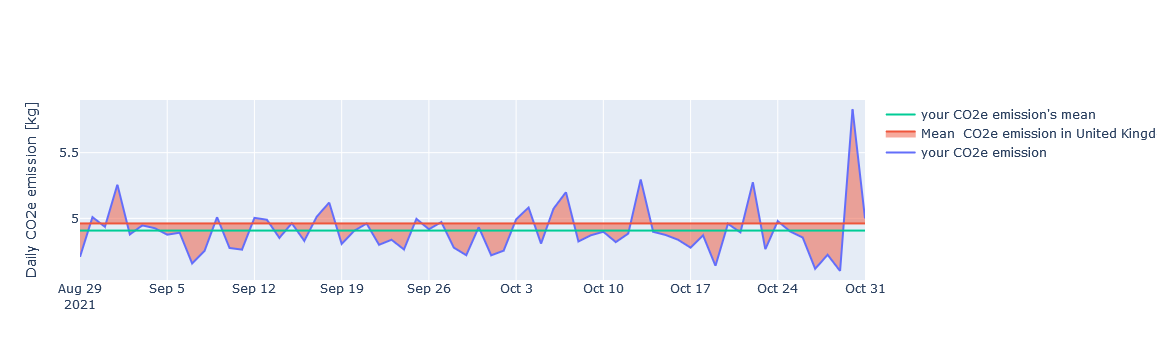

In [17]:
create_pie(wbkName)
plot_time_series(wbkName, country)